# Find daily Average Order Value (AOV).

1. *Perform the calculation in python.*
2. *Perform the calculation in aggregate query.*
3. *Which one is faster.*
4. *Plot the line plot on seaborn.*

\begin{equation}
AOV = \frac{revenue}{num.\, of\, orders}
\end{equation}

In [16]:
import pandas as pd
import import_ipynb
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from DBHandler import MongoDB as db

### Perform the calculation in python


In [3]:
bhmic_df = pd.DataFrame(list(db.getCollection().find()))
vergan_df = bhmic_df[bhmic_df['target'] == 'vergani']
bhmic_cart_df = pd.json_normalize(list(db.getCollection().find()), record_path='cart',meta=['target','date'])
vergan_cart_df = bhmic_cart_df[bhmic_cart_df['target'] == 'vergani']

daily_orders = vergan_cart_df['date'].dt.date.value_counts()
daily_revenue = vergan_cart_df.groupby(vergan_cart_df['date'].dt.date)['price'].sum()
pd_query = (daily_revenue / daily_orders).reset_index().rename(columns= {"index":"Date",0:"AOV"})

In [37]:
pd.DataFrame(pd_query)

,Date,AOV
0,2019-06-11,33.460000
1,2019-06-12,29.162500
2,2019-06-13,56.662500
3,2019-06-14,40.675000
4,2019-06-15,53.166667
...,...,...
58,2019-08-08,51.272093
59,2019-08-09,46.294444
60,2019-08-10,35.600000
61,2019-08-11,28.657143


### Perform the calculation in aggregate query.


In [11]:
pipeline = [
    {'$match': { 'target' : "vergani" } },
    {'$unwind': { 'path': "$cart" }},
    {'$group': { '_id': { '$dateToString': { 'format': "%Y-%m-%d", 'date': "$date" } },
    'totalAmount': { '$sum': "$cart.price" },
    'count': { '$sum': 1 } } },
    {'$project': {'_id': 0,'Date': '$_id', 'AOV': { '$divide': [ "$totalAmount", "$count" ] } } },
    {'$sort':{'Date': 1}}
]
#{"$multiply": [ "$cart.price", "$cart.amount" ] }

agg_query = db.getCollection().aggregate(pipeline)

In [39]:
pd.DataFrame(list(agg_query))

,Date,AOV
0,2019-06-11,33.460000
1,2019-06-12,29.162500
2,2019-06-13,56.662500
3,2019-06-14,40.675000
4,2019-06-15,53.166667
...,...,...
58,2019-08-08,51.272093
59,2019-08-09,46.294444
60,2019-08-10,35.600000
61,2019-08-11,28.657143


### Which one is faster

In [8]:
%%timeit
bhmic_df = pd.DataFrame(list(db.getCollection().find()))
vergan_df = bhmic_df[bhmic_df['target'] == 'vergani']
bhmic_cart_df = pd.json_normalize(list(db.getCollection().find()), record_path='cart',meta=['target','date'])
vergan_cart_df = bhmic_cart_df[bhmic_cart_df['target'] == 'vergani']

daily_orders = vergan_cart_df['date'].dt.date.value_counts()
daily_revenue = vergan_cart_df.groupby(vergan_cart_df['date'].dt.date)['price'].sum()
(daily_revenue / daily_orders).reset_index().rename(columns= {"index":"Date",0:"AOV"})

126 ms ± 867 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
pipeline = [
    {'$match': { 'target' : "vergani" } },
    {'$unwind': { 'path': "$cart" }},
    {'$group': { '_id': { '$dateToString': { 'format': "%Y-%m-%d", 'date': "$date" } },
    'totalAmount': { '$sum': "$cart.price" },
    'count': { '$sum': 1 } } },
    {'$project': {'_id': 0,'Date': '$_id', 'AOV': { '$divide': [ "$totalAmount", "$count" ] } } },
    {'$sort':{'Date': 1}}
]
db.getCollection().aggregate(pipeline)

7.35 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Plot the line plot on seaborn

In [12]:
df = pd.DataFrame(db.getCollection().aggregate(pipeline))

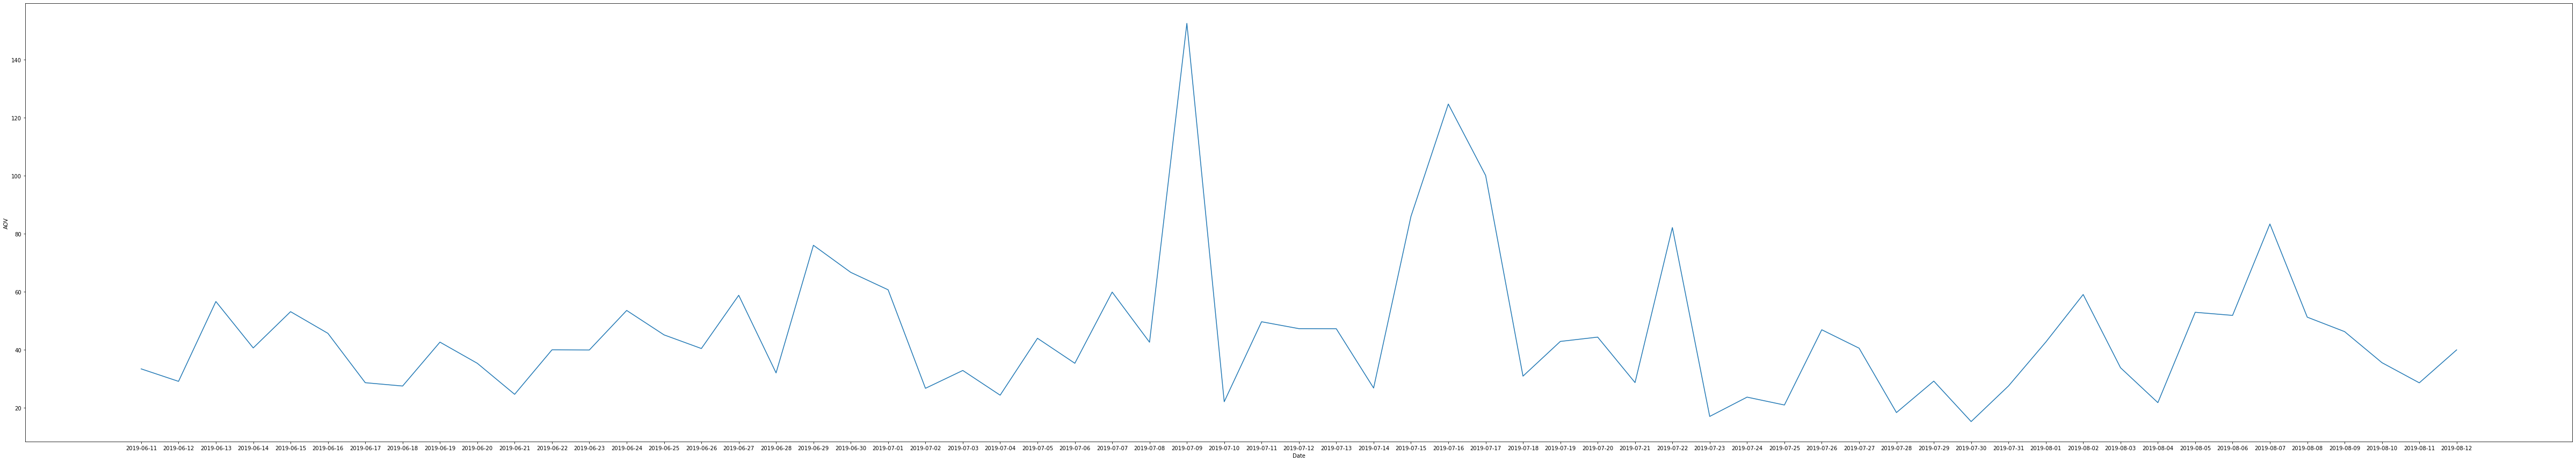

In [19]:
plt.figure(figsize=(85, 15))
g = sns.lineplot(x = "Date", y = "AOV", data=df)
g.figure.savefig("AOV.png")